In [1]:
#!pip install openai
#!pip install pymongo
#!pip install -U llama-index llama-index-readers-mongodb

In [1]:
# CONFIGURATION

import os

os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

os.environ["LANGCHAIN_API_KEY"]    = ""
os.environ["LANGCHAIN_ENDPOINT"]   = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.messages import SystemMessage, HumanMessage

from typing import TypedDict, Annotated, List
from langchain_core.pydantic_v1 import BaseModel

class Answers(BaseModel):
    answers: List[str]

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model.with_structured_output(Answers).invoke([HumanMessage(content="how many colors can fishes have. Generate two answers")])

Answers(answers=['Fishes can have a wide range of colors, including but not limited to red, blue, yellow, green, orange, purple, black, and white. Some species can even change colors based on their environment or mood.', 'The number of colors that fishes can exhibit is vast, with some species displaying iridescent patterns, stripes, or spots, leading to an almost infinite variety of color combinations.'])

In [3]:
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

from langgraph.checkpoint.sqlite import SqliteSaver

# -------- CONFIGURE GOALS ----------
GOAL = "healthy eating"

TASK_DEF = "Create a plan for a conversation with a user to discuss about "+GOAL+"."
RESULT_P = ""
debug_print = True

class AgentState(TypedDict):
    task: str
    plan_results: str
    research_results: List[str]
    answer: str

from openai import OpenAI
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

PLAN_PROMPT = """You are a subject matter expert tasked with outlining a plan to research a \
topic. Write the outline for the sections of the topic along with instructions to be used to \
research each section. Generate only 3 sections maximum."""

def plan_node(state: AgentState):
    if debug_print: print("--- Input TASK:", state['task'])
    messages = [ SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state['task']) ]
    response = model.invoke(messages)
    if debug_print: print("--- Output PLAN:", response.content)
    return {"plan_results": response.content}

SEARCH_PROMPT = """You are a researcher who will use a plan outline to research a particular topic \
and generate a list of search queries to gather relevant information for the sections in the outline. \
Generate only 2 queries maximum."""
    
def research_node(state: AgentState):
    class Queries(BaseModel):
        queries: List[str]
    if debug_print: print("Input Task:", state['task'])
    research_results = state['research_results'] or []
    task = state['task'] + " Follow this plan: " + state['plan_results']
    queries = model.with_structured_output(Queries).invoke([ SystemMessage(content=SEARCH_PROMPT), HumanMessage(content=task) ])
    for q in queries.queries:
        if debug_print: print("--- Research Query:", q)
        response = tavily.search(query=q, max_results=1)
        for r in response['results']:
            if debug_print: print("--- Query Result:-----",r['content'],"-------")
            research_results.append(r['content'])
    return {"research_results": research_results}


WRITER_PROMPT = """You are a writer, you're given a TASK, a PLAN, and RESEARCH RESULTS \
that you will want to use to accomplish the TASK. Generate an answer to the task. Keep the response \
to 5 sentences.    \
<<<TASK>>>: {}     \
                   \
<<<PLAN>>>: {}     \
                   \
<<<RESEARCH>>>: {} \
"""

def write_node(state: AgentState):
    research_results = "\n\n".join(state['research_results'] or [])
    user_message = WRITER_PROMPT.format(state['task'], state['plan_results'], research_results)
    if debug_print: print("--- Generation User Message:", user_message)
    response = model.invoke([ HumanMessage(content=user_message) ])
    if debug_print: print("--- Generation Response:", response.content)
    return {"answer": response.content}
    
def should_continue(state):
    return END
    
# Build the Graph
builder = StateGraph(AgentState)
builder.add_node("plan",     plan_node)
builder.add_node("research", research_node)
builder.add_node("write",    write_node)

builder.set_entry_point("plan")
builder.add_edge("plan", "research")
builder.add_edge("research", "write")
builder.add_conditional_edges("write", should_continue, {END: END, "research": "research", "plan":"plan"})

graph = builder.compile()


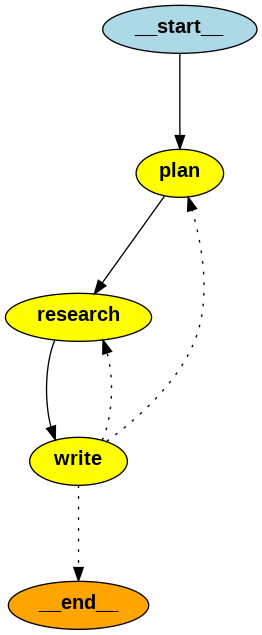

In [4]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [5]:
for idx, s in enumerate(graph.stream({'task':TASK_DEF}, {"configurable": {"thread_id": "1"}})):
    print("Stream:",idx, "stream:", s)
    print("---------------------------")
RESULT_P = s['write']['answer']
print("End Results")

--- Input TASK: Create a plan for a conversation with a user to discuss about healthy eating.
--- Output PLAN: ### Outline for Researching Healthy Eating

#### Section 1: Understanding Healthy Eating Principles
- **Instructions for Research:**
  1. Review reputable sources such as the USDA Dietary Guidelines, World Health Organization (WHO) recommendations, and registered dietitian resources.
  2. Summarize key principles of healthy eating, including macronutrients (carbohydrates, proteins, fats), micronutrients (vitamins, minerals), and hydration.
  3. Investigate common dietary patterns (e.g., Mediterranean, DASH, plant-based) and their health benefits.
  4. Compile statistics on the impact of healthy eating on overall health, including disease prevention and weight management.

#### Section 2: Common Myths and Misconceptions about Healthy Eating
- **Instructions for Research:**
  1. Identify prevalent myths surrounding healthy eating (e.g., "carbs are bad," "all fats are unhealthy")

In [6]:
RESULT_P

'To initiate a conversation about healthy eating, start by discussing the fundamental principles of nutrition, referencing the USDA Dietary Guidelines and the importance of macronutrients and micronutrients. Next, address common myths surrounding healthy eating, such as misconceptions about carbohydrates and fats, using evidence from reputable sources to debunk these myths. Transition into practical tips for implementing healthy eating habits, including meal planning and mindful eating strategies. Encourage the user to share their current eating habits and any challenges they face, fostering an open dialogue. Finally, offer to provide easy recipes and resources that align with their dietary preferences to support their journey toward healthier eating.'

In [7]:
import re
import time
from openai import OpenAI

def call_open_ai(prompt):
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # https://platform.openai.com/docs/models/overview
    # https://platform.openai.com/account/billing/preferences
    # https://platform.openai.com/account/usage
    
    messages=[{"role": "system", "content": ""}, {"role": "user", "content": prompt}]
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages) 
    return completion.choices[0].message.content

#print(call_open_ai("hello there"))

def make_recommendation_grounded_on_plan(plan, dialog):    
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    _dialog = dialog

    _prompt = """
    ### Instruction: Analyze the input Dialog and compare it to the input plan. \
    Recommend the next response that stays consistent with the plan. \
    If the current topic is different from the plan then provide an empty response. \
    If there is a response, make it as if instructing some one and keep the response to 1 to 2 sentences.

    ### Input:
    Input Plan:
    %s
    
    Input Dialog: 
    %s
    
    ### Response:
    """

    _prompt = _prompt % (plan, _dialog)
    
    messages=[{"role": "system", "content": ""}, {"role": "user", "content": _prompt}]
    
    completion = client.chat.completions.create(model="gpt-4o-mini", messages=messages) 

    result = completion.choices[0].message.content
        
    return result

dialog = """
hi, how are you doing
i'm doing great
what have you been up to
i've been eating lots of junk foods
"""

make_recommendation_grounded_on_plan(RESULT_P, dialog)

"It's important to evaluate your eating habits and consider the principles of nutrition. Let’s discuss how you can incorporate healthier options into your diet."

In [8]:
# -------------------
# Observer::System2
# -------------------
    
import json
import random
import pika

queue_manager_host = "localhost"

# Connect to Queue Manager
#connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))

def observe_dialog(ch, method, properties, body):
    body = json.loads(body)
    user = body['user']
    message_counter = body["message_counter"]
        
    print(f" [CallBack Input for user:{method.routing_key}] Dialog: {body['dialog']}")

    relevant_dialog = body["dialog"]
    message = make_recommendation_grounded_on_plan(RESULT_P, relevant_dialog)

    # Prepare reply ...
    exchange_name = method.routing_key   #'user1'
    queue_name = method.routing_key
    routing_key = 'system2'

    message_reply = {}
    message_reply["user"]=user
    message_reply["reply"]=message
    message_reply["message_counter"]=message_counter

    message_reply["image_prompt"] = message_reply["image_dscrpt"] = ""
        
    connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))
    channel = connection.channel()
    channel.exchange_declare(exchange=exchange_name, exchange_type='direct')
    
    #channel.queue_declare(queue=queue_name)
    result = channel.queue_declare(queue=queue_name)
    channel.queue_bind(exchange=exchange_name, queue=queue_name, routing_key=routing_key)
    channel.basic_publish(exchange=exchange_name, routing_key=routing_key, body=json.dumps(message_reply))

    if message=="": message="<<NO RECOMMENDATIONS>>"
    print(f" [CallBack Output for user:{method.routing_key}] Observer Type:{routing_key}, Message:{message}")
    connection.close()

exchange_name = "dialog_history"

connection = pika.BlockingConnection(pika.ConnectionParameters(host=queue_manager_host))
channel = connection.channel()
channel.exchange_declare(exchange=exchange_name, exchange_type='fanout')
result = channel.queue_declare(queue='', exclusive=True)
queue_name = result.method.queue
channel.queue_bind(exchange=exchange_name, queue=queue_name)

print(' [*] Waiting for dialogs. To exit press CTRL+C: name ->', queue_name)

channel.basic_consume(queue=queue_name, on_message_callback=observe_dialog, auto_ack=True)
channel.start_consuming()


 [*] Waiting for dialogs. To exit press CTRL+C: name -> amq.gen-JCDOJAi2yZiHa44KN4UR9A
 [CallBack Input for user:demo] Dialog: Assistant: hey, hows it going
User: I'm doing okay.

 [CallBack Output for user:demo] Observer Type:system2, Message:<<NO RECOMMENDATIONS>>
 [CallBack Input for user:demo] Dialog: Assistant: hey, hows it going
User: I'm doing okay.
Assistant: Glad to hear that! Is there anything specific on your mind today, or something you'd like to chat about?
User: can you recommend a topic

 [CallBack Output for user:demo] Observer Type:system2, Message:Let's discuss the fundamental principles of nutrition and the importance of macronutrients and micronutrients in a healthy diet. What are your thoughts on healthy eating?
 [CallBack Input for user:demo] Dialog: Assistant: hey, hows it going
User: I'm doing okay.
Assistant: Glad to hear that! Is there anything specific on your mind today, or something you'd like to chat about?
User: can you recommend a topic
Assistant: Macron

KeyboardInterrupt: 